# Chapter 4: Image Generation with GANs




This chapter covers:

* Creating an image from scratch by reverse engineering steps in the discriminator network. 
* Understanding how a 2D convolutional operator works on an image.
* Learning how a 2D transposed convolutional operation inserts gaps between the output values and generates feature maps of a higher resolution.
* Building and training GANs to generate grayscale and color images.

You have successfully generated an exponential growth curve shape and a sequence of integers that are all multiples of five in Chapter 3. Now that you understand how GANs work, you are ready to apply the same skillsets to generate many other forms of content: high-resolution color images, realistic-sounding music, and so on. However, this may be easier said than done (you know what they say, the devil is in the details). For example, exactly how can we make the generator conjure up realistic images out of thin air? That’s the question we’re going to tackle in this chapter.
The first takeaway from this chapter is: the generator can look at what the discriminator is doing and reverse engineer the steps in the discriminator network to create images from scratch. In the first project in this chapter, your goal is to create grayscale images of clothing items such as coats, shirts, sandals, and so on (yes, the same items you have seen in Chapter 2). The generator looks at the discriminator network and reverse-engineers the process to create grayscale clothing items. Specifically, a grayscale image (either real or fake) goes through four fully connected dense layers sequentially in the discriminator network and the output is the probability that the image is real. To create an image, the generator uses four similar fully connected dense layers, but in reverse order. In each layer, the numbers of inputs and outputs in the discriminator network are reversed, and then used as the numbers of outputs and inputs in the generator network. As a result, the generator conjures up a 784-value tensor, which is then reshaped into a 28 by 28 grayscale image.
The second takeaway in this chapter is: to generate high-resolution color images, we need something more sophisticated than fully connected dense layers. Specifically, we’ll use convolutional neural networks (CNNs), which are commonly used in image processing and computer vision tasks. We'll use convolutional layers to treat images as 2D objects and extract spatial features from them. Further, we'll also use transposed convolutional layers (also known as deconvolution or upsampling Layers) to generate high-resolution feature maps.
In the second project in this chapter, your goal is to create color images of Anime faces. Like in the first project, the generator looks at the discriminator network and reverse-engineers the process to conjure up images. However, instead of using dense layers, the discriminator in this project uses five 2D convolutional layers. To create an image, the generator uses five symmetric 2D transposed convolutional layers in reverse order: it obtains a random noise vector from the latent space, feeds the vector through five 2D transposed convolutional layers, and comes up with a high-resolution color image.
To summarize, you’ll learn how to reverse engineer the steps in the discriminator network to create images from scratch in this chapter. In addition, you’ll learn how convolutional layers and transposed convolutional layers work. After this chapter, readers will use convolutional layers and transposed convolutional layers to create high-resolution images in other settings later in this book (such as in feature transfers when training a CycleGAN to convert a horse image to a zebra image or in a Variational Autoencoder to generate high-resolution human face images). 

# 1.  GANs to Generate Grayscale Images of Clothing Items

## 1.1. Training Samples and the Discriminator
First, let's download the Fashion MNIST data directly from Torchvision datasets, as you did in Chapter 2. 

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T

torch.manual_seed(42)
transform=T.Compose([
    T.ToTensor(),
    T.Normalize([0.5],[0.5])])

/opt/conda/envs/audiocraft/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_set=torchvision.datasets.FashionMNIST(
    root=".",
    train=True,
    download=True,
    transform=transform) 

In [3]:
batch_size=32
train_loader=torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True)

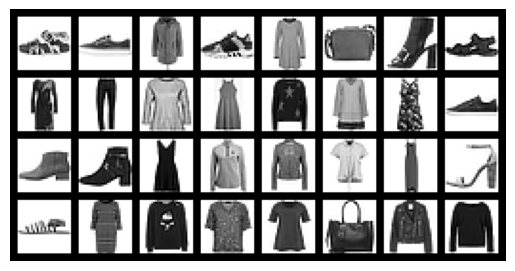

In [4]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

images, labels = next(iter(train_loader))
# Plot all the images of the 1st batch in grid
grid = make_grid(0.5-images/2, 8, 4)
plt.imshow(grid.numpy().transpose((1, 2, 0)),
          cmap="gray_r")
plt.axis("off")
plt.show()

In [5]:
import torch
import torch.nn as nn

# determine the device automatically
device="cuda" if torch.cuda.is_available() else "cpu"
# the discriminator D is a binary classifier
D=nn.Sequential(
    nn.Linear(784, 1024),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 1),
    nn.Sigmoid()).to(device)

## 1.2	A Generator to Create Grayscale Images

In [6]:
G=nn.Sequential(
    nn.Linear(100, 256),
    nn.ReLU(),
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Linear(1024, 784),
    nn.Tanh()).to(device)

In [7]:
loss_fn=nn.BCELoss()
lr=0.0001
optimD=torch.optim.Adam(D.parameters(),lr=lr)
optimG=torch.optim.Adam(G.parameters(),lr=lr)

## 1.3	Train GANs to Generate Images of Clothing Items

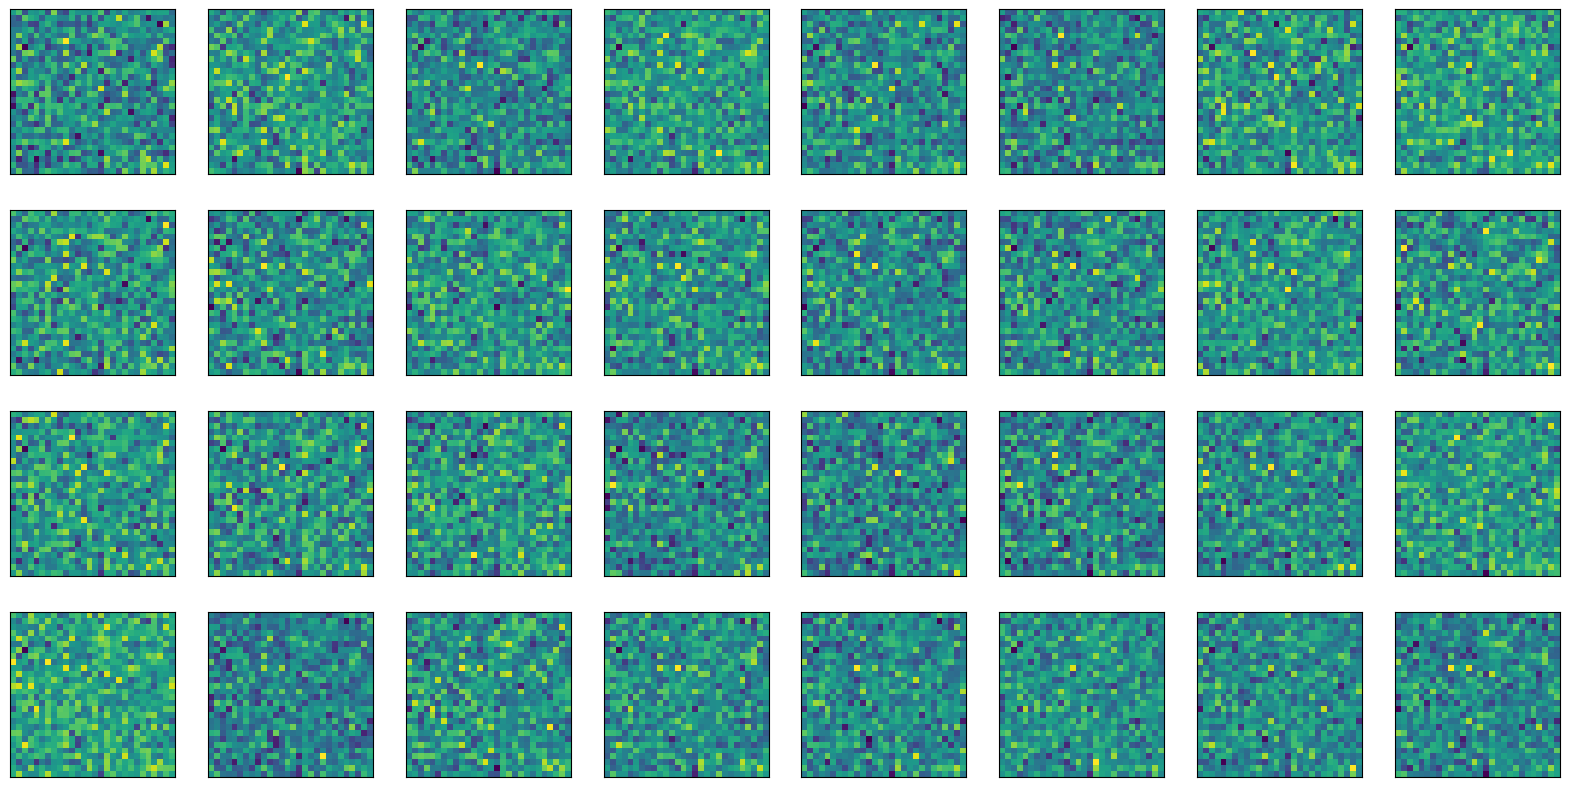

In [8]:
import matplotlib.pyplot as plt

def see_output():
    noise=torch.randn(32,100).to(device=device)
    fake_samples=G(noise).cpu().detach()    #A
    plt.figure(dpi=100,figsize=(20,10))
    for i in range(32):
        ax=plt.subplot(4, 8, i + 1)    #B
        img=(fake_samples[i]/2+0.5).reshape(28, 28)
        plt.imshow(img)    #C
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
see_output()    #D     

In [9]:
real_labels=torch.ones((batch_size,1)).to(device)
fake_labels=torch.zeros((batch_size,1)).to(device)

In [10]:
def train_D_on_real(real_samples):
    #r=torch.FloatTensor(real_samples)
    r=real_samples.reshape(-1,28*28).to(device)
    out_D=D(r)    
    labels=torch.ones((r.shape[0],1)).to(device)
    loss_D=loss_fn(out_D,labels)    
    optimD.zero_grad()
    loss_D.backward()
    optimD.step()    
    return loss_D

In [11]:
def train_D_on_fake():        
    noise=torch.randn(batch_size,100).to(device=device)
    generated_data=G(noise)
    preds=D(generated_data)
    loss_D=loss_fn(preds,fake_labels)
    optimD.zero_grad()
    loss_D.backward()
    optimD.step()
    return loss_D

In [12]:
def train_G(): 
    noise=torch.randn(batch_size,100).to(device=device)
    generated_data=G(noise)
    preds=D(generated_data)
    loss_G=loss_fn(preds,real_labels)
    optimG.zero_grad()
    loss_G.backward()
    optimG.step()
    return loss_G

In [ ]:
for i in range(50):
    gloss=0
    dloss=0
    for n, (real_samples,_) in enumerate(train_loader):
        loss_D=train_D_on_real(real_samples)
        dloss+=loss_D
        loss_D=train_D_on_fake()
        dloss+=loss_D
        loss_G=train_G()
        gloss+=loss_G
    gloss=gloss/n
    dloss=dloss/n    
    if i % 10 == 9:
        print(f"at epoch {i+1}, dloss: {dloss}, gloss {gloss}")
        see_output()

In [ ]:
# Export to TorchScript
scripted = torch.jit.script(G) 
# Save the model
import os
os.makedirs("files", exist_ok=True)
scripted.save('files/fashion_gen.pt') 

In [ ]:
new_G=torch.jit.load('files/fashion_gen.pt',
                     map_location=device)
new_G.eval()

In [ ]:
noise=torch.randn(batch_size,100).to(device=device)
fake_samples=new_G(noise).cpu().detach()
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow((fake_samples[i]/2+0.5).reshape(28, 28))
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(hspace=-0.6)
plt.show() 

# 2	Convolutional Layers 
## 2.1	How do convolutional operations work?

In [ ]:
import torch
torch.manual_seed(42)

img = torch.Tensor([[1,1,1],
                    [0,1,2],
                    [8,7,6]]).reshape(1,1,3,3)    

In [ ]:
import torch.nn as nn

conv=nn.Conv2d(in_channels=1,
            out_channels=1,
            kernel_size=2, 
            stride=1)    #A
sd=conv.state_dict()    #B
print(sd)

In [ ]:
weights={'weight':torch.tensor([[[[1,2],
   [3,4]]]]), 'bias':torch.tensor([0])}    #A
for k in sd:
    with torch.no_grad():
        sd[k].copy_(weights[k])    #B
print(conv.state_dict())    

In [ ]:
output = conv(img)
print(output)

## 2.2	How do stride and padding affect convolutional operations?

In [ ]:
conv=nn.Conv2d(in_channels=1,
            out_channels=1,
            kernel_size=2, 
            stride=2,    #A
            padding=1)    #B
sd=conv.state_dict()
for k in sd:
    with torch.no_grad():
        sd[k].copy_(weights[k])
output = conv(img)
print(output)

# 3	Transposed Convolution and Batch Normalization
## 3.1	How do transposed convolutional layers work?

In [ ]:
img = torch.Tensor([[1,0],
                    [2,3]]).reshape(1,1,2,2)

In [ ]:
transconv=nn.ConvTranspose2d(in_channels=1,
            out_channels=1,
            kernel_size=2, 
            stride=2)    #A
sd=transconv.state_dict()
weights={'weight':torch.tensor([[[[2,3],
   [4,5]]]]), 'bias':torch.tensor([0])}
for k in sd:
    with torch.no_grad():
        sd[k].copy_(weights[k])    #B

In [ ]:
transoutput = transconv(img)
print(transoutput)

## 3.2	Batch Normalization

In [ ]:
torch.manual_seed(42)    #A 
img = torch.rand(1,3,64,64)    #B
conv = nn.Conv2d(in_channels=3,
            out_channels=3,
            kernel_size=3, 
            stride=1,
            padding=1)    #C
out=conv(img)    #D
print(out.shape)

In [ ]:
for i in range(3):
    print(f"mean in channel {i} is", out[:,i,:,:].mean().item())
    print(f"std in channel {i} is", out[:,i,:,:].std().item())

In [ ]:
norm=nn.BatchNorm2d(3)
out2=norm(out)
print(out2.shape)
for i in range(3):
    print(f"mean in channel {i} is", out2[:,i,:,:].mean().item())
    print(f"std in channel {i} is", out2[:,i,:,:].std().item())

# 4	GANs to Generate Color Images of Anime Faces
## 4.1	Download Anime Faces

In [ ]:
# download data from https://www.kaggle.com/datasets/splcher/animefacedataset
# modify the path based on where you saved the training data
anime_path = r"files/anime"

In [ ]:
from torchvision import transforms as T
from torchvision.datasets import ImageFolder

transform = T.Compose([T.Resize((64, 64)),
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
train_data = ImageFolder(root=anime_path,
                         transform=transform)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 128
train_loader = DataLoader(dataset=train_data, 
               batch_size=batch_size, shuffle=True)

## 4.2. Channels First Color Images

In [ ]:
image0, _ = train_data[0]
print(image0.shape)

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(image0.permute(1,2,0)*0.5+0.5)
plt.show()

In [ ]:
def plot_images(imgs):
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        plt.imshow(imgs[i].permute(1,2,0)/2+0.5)
        plt.xticks([])
        plt.yticks([])
    plt.subplots_adjust(hspace=-0.6)
    plt.show()  

imgs, _ = next(iter(train_loader))
plot_images(imgs)

# 5	Building a Deep Convolutional GAN (DCGAN) 

## 5.1. A Discriminator in DCGAN

In [ ]:
import torch.nn as nn
import torch

# determine the device automatically
device = "cuda" if torch.cuda.is_available() else "cpu"
D = nn.Sequential(
    nn.Conv2d(3, 64, 4, 2, 1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(64, 128, 4, 2, 1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(128, 256, 4, 2, 1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(256, 512, 4, 2, 1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(512, 1, 4, 1, 0, bias=False),
    nn.Sigmoid(),
    nn.Flatten()).to(device)

## 5.2	Creating A Generator in DCGAN

In [ ]:
G=nn.Sequential(
    nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
    nn.Tanh()).to(device)

In [ ]:
loss_fn=nn.BCELoss()
lr = 0.0002
optimG = torch.optim.Adam(G.parameters(), 
                         lr = lr, betas=(0.5, 0.999))
optimD = torch.optim.Adam(D.parameters(), 
                         lr = lr, betas=(0.5, 0.999))

# 6. Train and Use DCGAN

In [ ]:
def test_epoch():
    noise=torch.randn(32,100,1,1).\
        to(device=device)    #A
    fake_samples=G(noise).cpu().detach()    #B
    for i in range(32):    #C
        ax = plt.subplot(4, 8, i + 1)
        img=(fake_samples.cpu().detach()[i]/2+0.5).\
            permute(1,2,0)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.subplots_adjust(hspace=-0.6)
    plt.show()
test_epoch()    #D     

In [ ]:
real_labels=torch.ones((batch_size,1)).to(device)
fake_labels=torch.zeros((batch_size,1)).to(device)

In [ ]:
def train_D_on_real(real_samples):
    real_samples=real_samples.to(device)
    preds=D(real_samples)
    labels=torch.ones((real_samples.shape[0],1)).to(device)
    loss_D=loss_fn(preds,labels)
    optimD.zero_grad()
    loss_D.backward()
    optimD.step()
    return loss_D  

In [ ]:
def train_D_on_fake():
    noise=torch.randn(batch_size,100,1,1).to(device)
    generated_data=G(noise)
    preds=D(generated_data)
    loss_D=loss_fn(preds,fake_labels)
    optimD.zero_grad()
    loss_D.backward()
    optimD.step()
    return loss_D 

In [ ]:
def train_G():
    noise=torch.randn(batch_size,100,1,1).to(device)
    generated_data=G(noise)
    preds=D(generated_data)
    loss_G=loss_fn(preds,real_labels)
    optimG.zero_grad()
    loss_G.backward()
    optimG.step()
    return loss_G   

In [ ]:
for i in range(20):
    gloss=0
    dloss=0
    for n, (real_samples,_) in enumerate(train_loader):    
        loss_D=train_D_on_real(real_samples)
        dloss+=loss_D
        loss_D=train_D_on_fake()
        dloss+=loss_D
        loss_G=train_G()
        gloss+=loss_G
    gloss=gloss/n
    dloss=dloss/n
    print(f"epoch {i+1}, dloss: {dloss}, gloss {gloss}")
    test_epoch()

In [ ]:
# Export to TorchScript
scripted = torch.jit.script(G) 
scripted.save('files/anime_gen.pt') 

In [ ]:
new_G=torch.jit.load('files/anime_gen.pt',
                     map_location=device)
new_G.eval()
noise=torch.randn(32,100,1,1).to(device)
fake_samples=new_G(noise).cpu().detach()
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    img=(fake_samples.cpu().detach()[i]/2+0.5).permute(1,2,0)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(hspace=-0.6)
plt.show() 

In [ ]:
# exercise 4.1
D=nn.Sequential(
    nn.Linear(784, 1000),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1000, 500),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(500, 200),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(200, 1),
    nn.Sigmoid()).to(device)

In [ ]:
# exercise 4.2
G=nn.Sequential(
    nn.Linear(100, 200),
    nn.ReLU(),
    nn.Linear(200, 500),
    nn.ReLU(),
    nn.Linear(500, 1000),
    nn.ReLU(),
    nn.Linear(1000, 784),
    nn.Tanh()).to(device)

exercise 4.3

When the filter bottom right corner of the image, the covered area has values [[1, 2], [7, 6]]. The filter has values [[1,2],[3,4]]. The convolution operation finds the sum of the element-wise multiplication of the two tensors. Therefore, the output from scanning the bottom right corner is:
1*1+2*2+7*3+6*4=50.

In [ ]:
# exercise 4.4
import torch
from torch import nn

img = torch.Tensor([[10,10],
                    [15,20]]).reshape(1,1,2,2)

transconv=nn.ConvTranspose2d(in_channels=1,
            out_channels=1,
            kernel_size=2, 
            stride=2)    
sd=transconv.state_dict()
weights={'weight':torch.tensor([[[[2,3],
   [4,5]]]]), 'bias':torch.tensor([0])}
for k in sd:
    with torch.no_grad():
        sd[k].copy_(weights[k])    

transoutput = transconv(img)
print(transoutput)